## Transformation accuracy analysis
Check the accuracy of coordinate transformation with automatic detection of beads, calculation of transformation map, and finally comparison of the transformed wf coordinates with the real scan coordinates.

In [1]:
import os
import csv
import glob
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import tifffile
import h5py
from scipy import ndimage as ndi
import cv2 as cv
from scipy.optimize import least_squares

In [2]:
pxs = 0.080  # pixel size in um
imsize = 80  # image width and height in um

params_fit = [-1.188033331880831518e-09,1.097083366010643169e-09,-5.273500980338464584e-10,-1.744396884715451083e-10,
              2.612140597226462025e-06,-8.785963639722968196e-07,3.814454330947862371e-07,1.005218160888972645e-01,
              1.545471775768740130e-03,-4.180114799086727118e+01,1.268104888235232562e-09,-7.930701548649460406e-11,
              2.860267189879632174e-09,-4.779925076064363007e-10,-2.890527398129946892e-06,7.262138637063089313e-07,
              -2.423884516814759662e-06,2.900644474070668971e-03,-1.019673565794493308e-01,3.971132215492339412e+01]

def wf_800_scan_80(coords_input, imsize=80, pxs=0.08):
    params_fit = [1.002858674427358041e-10, -5.240401525310020974e-10, 1.834583799961432558e-09, -1.449897532883345736e-09, 2.555844605542734214e-07, 1.514999542949031523e-06, -4.180673354986260134e-07, 
                    1.014525026211505893e-01, 8.629923059170694884e-04, -4.157391401422187727e+01, 2.142237090571925601e-10, 1.300369670206358512e-09, 2.762006005482369079e-09, -1.010201724679422243e-09, 
                    -1.394117771504076619e-06, -7.098422279081016279e-07, -2.044544202054116206e-06, 2.299631030223449508e-03, -1.015491308219887978e-01, 3.961925553404672229e+01]

    c1 = coords_input[0]
    c2 = coords_input[1]
    x_i1 = params_fit[0]*c1**3 + params_fit[1]*c2**3 + params_fit[2]*c2*c1**2 + params_fit[3]*c1*c2**2 + params_fit[4]*c1**2 + params_fit[5]*c2**2 + params_fit[6]*c1*c2 + params_fit[7]*c1 + params_fit[8]*c2 + params_fit[9]
    x_i2 = params_fit[10]*c1**3 + params_fit[11]*c2**3 + params_fit[12]*c2*c1**2 + params_fit[13]*c1*c2**2 + params_fit[14]*c1**2 + params_fit[15]*c2**2 + params_fit[16]*c1*c2 + params_fit[17]*c1 + params_fit[18]*c2 + params_fit[19]
    coords = [x_i1, -x_i2]
    coords_out = [int(round((coord+imsize/2)/pxs)) for coord in coords]
    return coords_out

def poly_thirdorder_transform(a, x):
    """ Use for plotting the least-squares fit results.
    """
    c1 = x[0]
    c2 = x[1]
    x_i1 = a[0]*c1**3 + a[1]*c2**3 + a[2]*c2*c1**2 + a[3]*c1*c2**2 + a[4]*c1**2 + a[5]*c2**2 + a[6]*c1*c2 + a[7]*c1 + a[8]*c2 + a[9]
    x_i2 = a[10]*c1**3 + a[11]*c2**3 + a[12]*c2*c1**2 + a[13]*c1*c2**2 + a[14]*c1**2 + a[15]*c2**2 + a[16]*c1*c2 + a[17]*c1 + a[18]*c2 + a[19]
    return (x_i1, x_i2)

def coordinateTransformCalibrate(wf_coords, scan_coords):
    """ Third-order polynomial fitting with least-squares Levenberg-Marquart algorithm.
    """
    # prepare data and init guess
    c_init = np.hstack([np.zeros(10), np.zeros(10)])
    xdata = np.array([*wf_coords]).astype(np.float32)
    ydata = np.array([*scan_coords]).astype(np.float32)
    initguess = c_init.astype(np.float32)
    
    print(xdata), print(ydata)
    # fit
    res_lsq = least_squares(poly_thirdorder, initguess, args=(xdata, ydata), method='lm')
    transform_coeffs = res_lsq.x
    #transform_coeffs = [val*10 for val in transform_coeffs]
    return transform_coeffs

def poly_thirdorder(a, x, y):
    """ Polynomial function that will be fit in the least-squares fit. 
    """
    res = []
    for i in range(0, len(x)):
        c1 = x[i,0]
        c2 = x[i,1]
        x_i1 = a[0]*c1**3 + a[1]*c2**3 + a[2]*c2*c1**2 + a[3]*c1*c2**2 + a[4]*c1**2 + a[5]*c2**2 + a[6]*c1*c2 + a[7]*c1 + a[8]*c2 + a[9]
        x_i2 = a[10]*c1**3 + a[11]*c2**3 + a[12]*c2*c1**2 + a[13]*c1*c2**2 + a[14]*c1**2 + a[15]*c2**2 + a[16]*c1*c2 + a[17]*c1 + a[18]*c2 + a[19]
        res.append(x_i1 - y[i,0])
        res.append(x_i2 - y[i,1])
    return res

In [3]:
folder = 'example_data'

In [4]:
scanimgfile, wfimgfile = '',''
for file in os.listdir(folder):
    if file.endswith('APDgreen.hdf5'):
        scanimgfile = os.path.join(folder, file)
    elif file.endswith('Camera.hdf5'):
        wfimgfile = os.path.join(folder, file)
    elif file.endswith('scan.csv'):
        scancoordsfile = os.path.join(folder, file)
    elif file.endswith('wf.csv'):
        wfcoordsfile = os.path.join(folder, file)

print(scanimgfile)
print(wfimgfile)
print(scancoordsfile)
print(wfcoordsfile)

example_data\calib-scan561-80x80-20us_snap_APDgreen.hdf5
example_data\calib-wf-wf_ham_snap_smartSTEDCamera.hdf5
example_data\findmaxima_scan.csv
example_data\findmaxima_wf.csv


In [5]:
scanimg, wfimg = [],[]
f = h5py.File(wfimgfile, 'r')
wfimg = f["data:smartSTEDCamera"][...]
print(np.shape(wfimg))

f = h5py.File(scanimgfile, 'r')
scanimg = f["data:APDgreen"][...]
print(np.shape(scanimg))

(800, 800)
(1000, 1000)


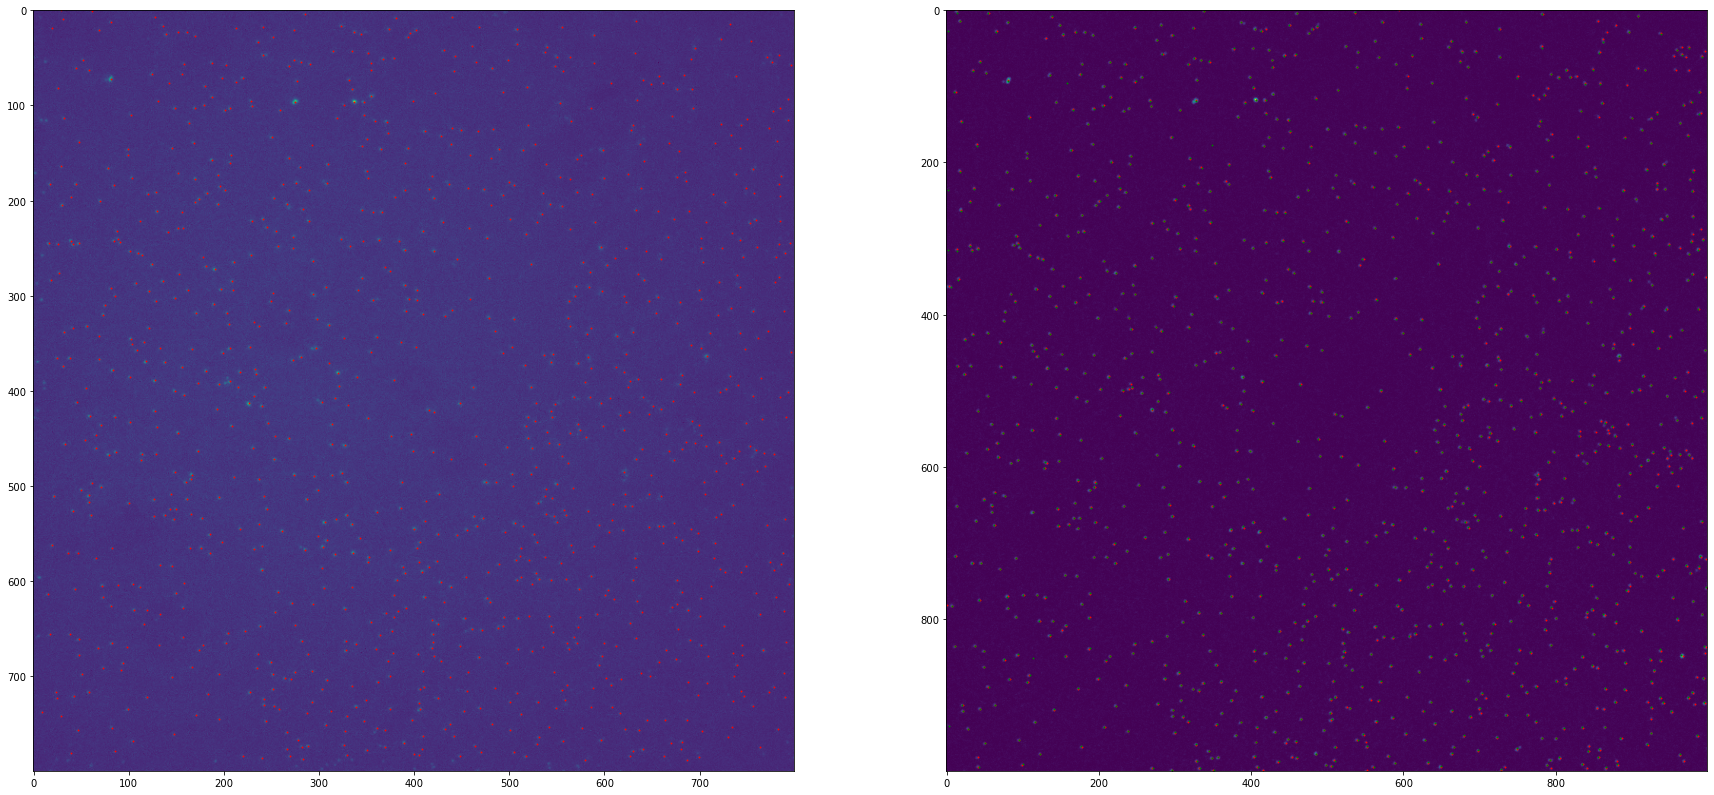

In [6]:
scan_x_px = []
scan_y_px = []
scan_x = []
scan_y = []
wf_x_px = []
wf_y_px = []
wf_x = []
wf_y = []
transf_x_px = []
transf_y_px = []

with open(scancoordsfile, newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader, None)
    for row in reader:
        scan_x_px.append(int(row[1]))
        scan_y_px.append(int(row[2]))
        scan_x.append(np.around(int(row[1])*pxs - imsize/2,3))
        scan_y.append(np.around(int(row[2])*pxs - imsize/2,3))
with open(wfcoordsfile, newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader, None)
    for row in reader:
        wf_x_px.append(int(row[1]))
        wf_y_px.append(int(row[2]))
        wf_x.append(int(row[1])*1)
        wf_y.append(int(row[2])*1)
        
idx_del_wf = []
for idx, coord_pair in enumerate(zip(wf_x, wf_y)):
    transf_pair = poly_thirdorder_transform(params_fit, coord_pair)
    transf_pair_px = (np.around((transf_pair[0] + imsize/2)/pxs, 0), np.around((-1 * transf_pair[1] + imsize/2)/pxs, 0))
    if transf_pair_px[0] > 0 and transf_pair_px[1] > 0 and transf_pair_px[0] < 1000 and transf_pair_px[1] < 1000:
        transf_x_px.append(transf_pair_px[0])
        transf_y_px.append(transf_pair_px[1])
    else:
        idx_del_wf.append(idx)
        
wf_x = [i for j, i in enumerate(wf_x) if j not in idx_del_wf]
wf_x_px = [i for j, i in enumerate(wf_x_px) if j not in idx_del_wf]
wf_y = [i for j, i in enumerate(wf_y) if j not in idx_del_wf]
wf_y_px = [i for j, i in enumerate(wf_y_px) if j not in idx_del_wf]

fig1, axs = plt.subplots(1, 2, figsize=(30,15))
axs[0].imshow(wfimg)
axs[0].scatter(wf_x, wf_y, s=3, marker='.', facecolors='red')
axs[1].imshow(scanimg)
axs[1].scatter(scan_x_px, scan_y_px, s=3, marker='.', facecolors='red')
axs[1].scatter(transf_x_px, transf_y_px, s=3, marker='.', facecolors='green')

1048
1048
1048
1048
1048


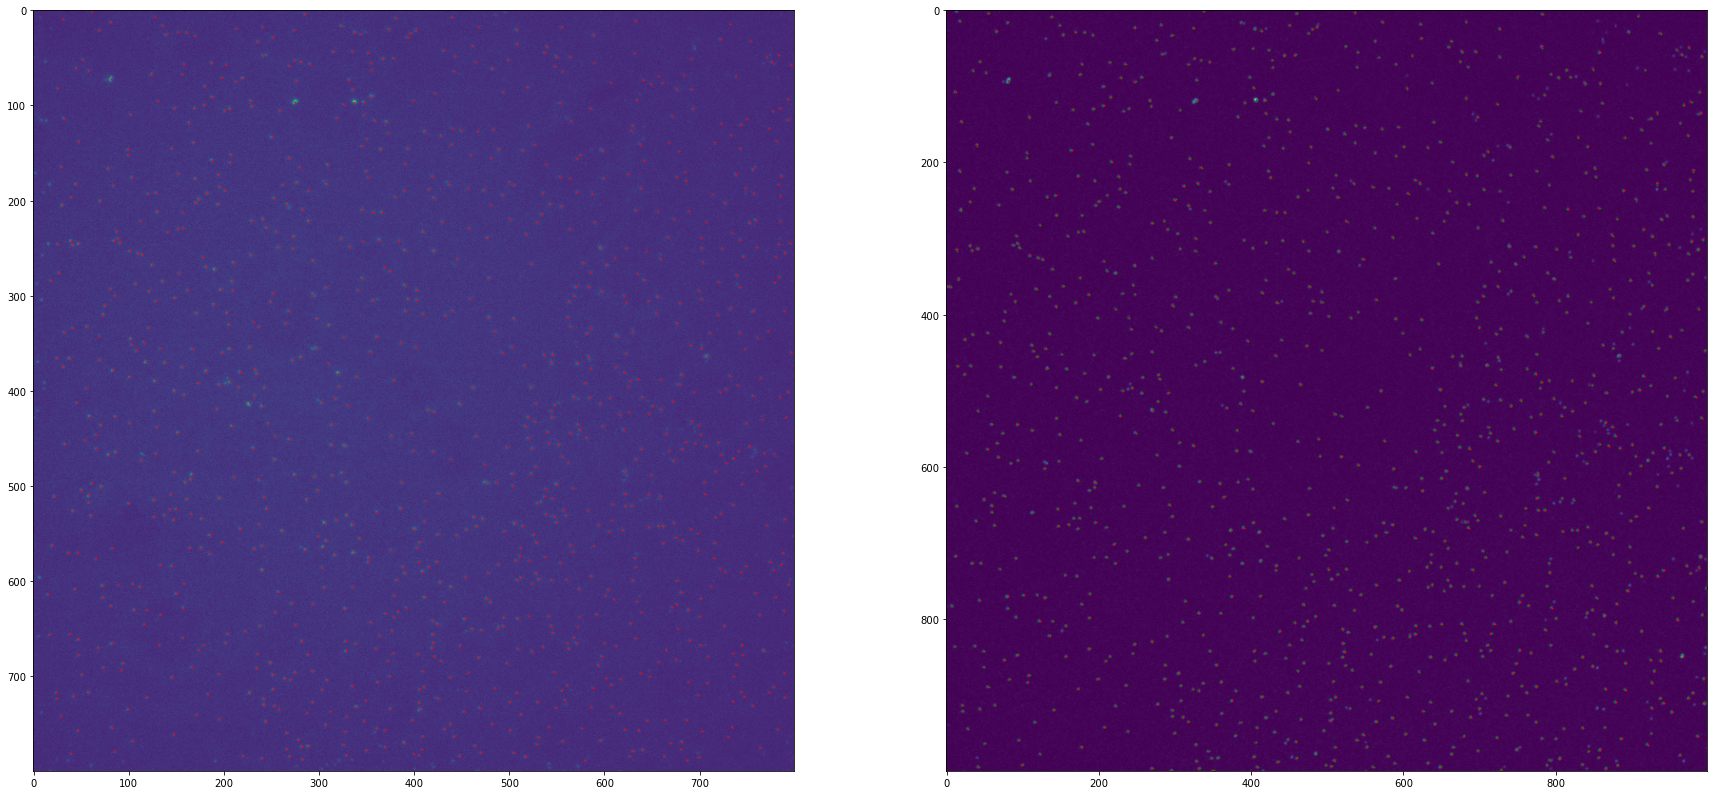

In [7]:
# check distance between closest neighbours and link pairs of transformed and scan coords
def distance(transf_pair, scan_pair):
    d = np.sqrt((transf_pair[0]-scan_pair[0])**2 + (transf_pair[1]-scan_pair[1])**2)
    return d

d_shortest = []
idxs = []
for idx_t, transf_pair in enumerate(zip(transf_x_px,transf_y_px)):
    d_short = np.inf
    idx_short = 0
    for idx_s, scan_pair in enumerate(zip(scan_x_px,scan_y_px)):
        d = distance(transf_pair, scan_pair)
        if d < d_short:
            d_short = d
            idx_short = idx_s
    if d_short < 3:
        idxs.append([idx_t, idx_short])
        d_shortest.append(d_short)
idxs = np.array(idxs)

idx_del_transf = []
idx_del_scan = []
for i in range(len(transf_x_px)):
    if i not in idxs[:,0]:
        idx_del_transf.append(i)
for i in range(len(scan_x_px)):
    if i not in idxs[:,1]:
        idx_del_scan.append(i)
wf_x_px = [i for j, i in enumerate(wf_x_px) if j not in idx_del_transf]
wf_y_px = [i for j, i in enumerate(wf_y_px) if j not in idx_del_transf]
wf_x = [i for j, i in enumerate(wf_x) if j not in idx_del_transf]
wf_y = [i for j, i in enumerate(wf_y) if j not in idx_del_transf]
transf_x_px = [i for j, i in enumerate(transf_x_px) if j not in idx_del_transf]
transf_y_px = [i for j, i in enumerate(transf_y_px) if j not in idx_del_transf]
scan_x_px = [i for j, i in enumerate(scan_x_px) if j not in idx_del_scan]
scan_y_px = [i for j, i in enumerate(scan_y_px) if j not in idx_del_scan]
scan_x = [i for j, i in enumerate(scan_x) if j not in idx_del_scan]
scan_y = [i for j, i in enumerate(scan_y) if j not in idx_del_scan]

print(len(wf_x_px)), print(len(wf_x)), print(len(transf_x_px)), print(len(scan_x_px)), print(len(scan_x))

fig1, axs = plt.subplots(1, 2, figsize=(30,15))
axs[0].imshow(wfimg)
axs[0].scatter(wf_x, wf_y, s=3, marker='.', facecolors='red')
axs[1].imshow(scanimg)
axs[1].scatter(scan_x_px, scan_y_px, s=3, marker='.', facecolors='red')
axs[1].scatter(transf_x_px, transf_y_px, s=3, marker='.', facecolors='green')

1048
1048
(1048, 2)
(1048, 2)
[[337.  96.]
 [275.  96.]
 [ 81.  72.]
 ...
 [750. 114.]
 [732.  14.]
 [785. 406.]]
[[ -7.44 -30.56]
 [-13.76 -30.56]
 [-33.52 -32.64]
 ...
 [ 34.72 -29.28]
 [ 32.72 -39.44]
 [ 38.72   0.64]]
[-1.47951070e-09 -4.03860289e-11  5.20142942e-11  4.92300365e-12
  2.99009641e-06  4.41734361e-07 -5.46319914e-08  1.00392557e-01
  1.15119217e-03 -4.17511555e+01 -2.84277183e-10 -1.25777013e-09
 -1.81241058e-09 -6.11654668e-11  1.08924670e-06  1.16090172e-06
  2.25716661e-06 -2.15163202e-03  1.01367960e-01 -3.97570335e+01]


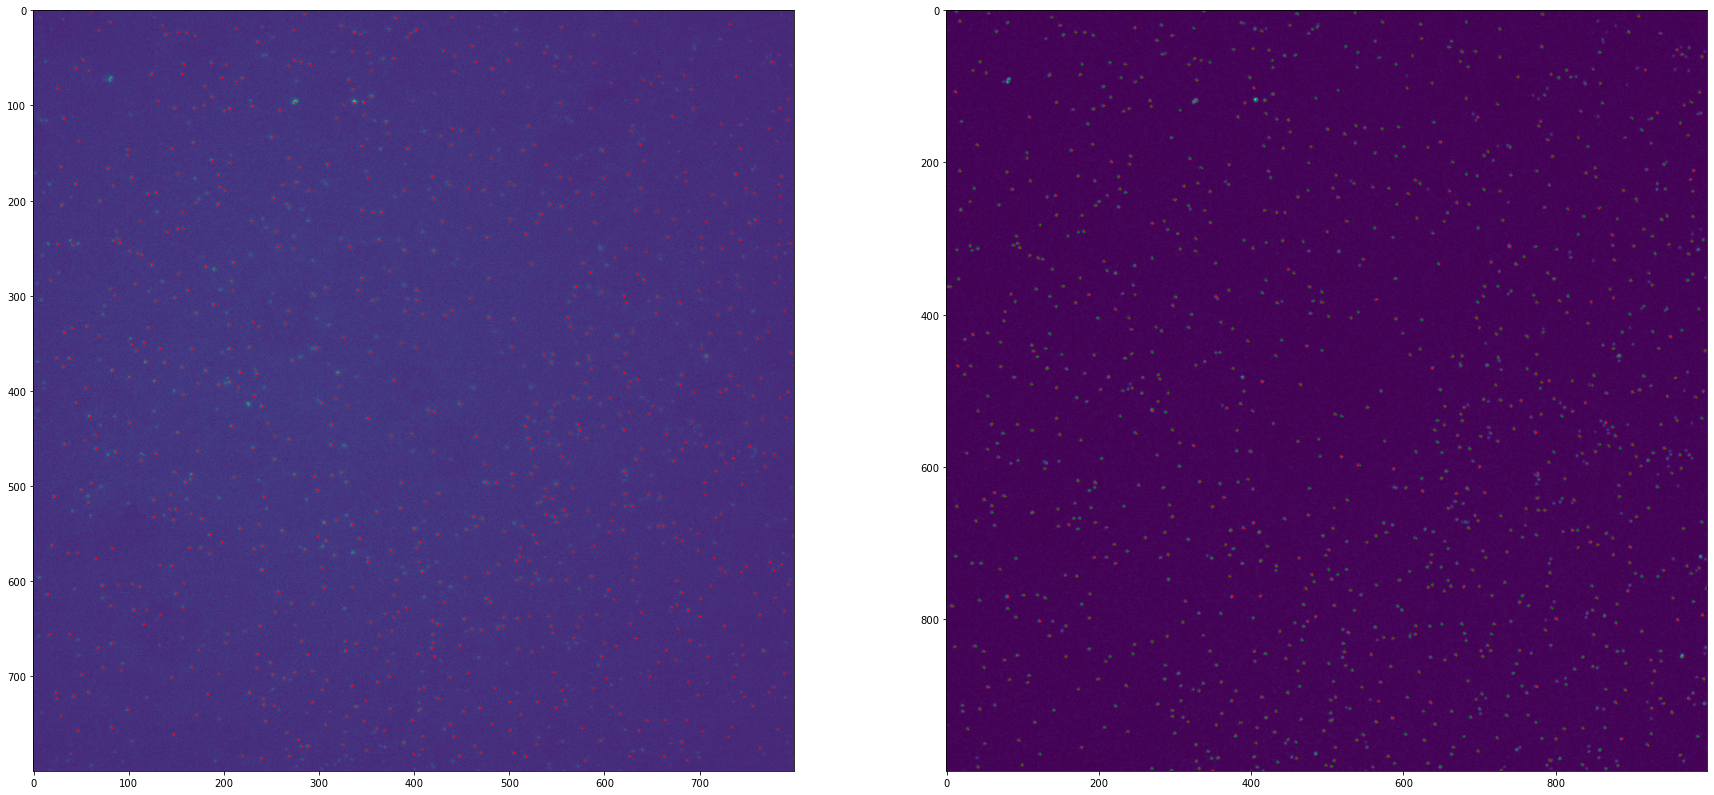

In [8]:
# order pairs properly, make another transform, with all the detected points taken into account, and plot resulting transformed coords
idxs = []
for idx_t, transf_pair in enumerate(zip(transf_x_px,transf_y_px)):
    d_short = np.inf
    idx_short = 0
    for idx_s, scan_pair in enumerate(zip(scan_x_px,scan_y_px)):
        d = distance(transf_pair, scan_pair)
        if d < d_short:
            d_short = d
            idx_short = idx_s
    idxs.append([idx_t, idx_short])
idxs = np.array(idxs)

wf_x = np.array(wf_x)
wf_y = np.array(wf_y)
scan_x = np.array(scan_x)
scan_y = np.array(scan_y)
wf_x = wf_x[idxs[:,0]]
wf_y = wf_y[idxs[:,0]]
scan_x = scan_x[idxs[:,1]]
scan_y = scan_y[idxs[:,1]]

print(len(scan_x)), print(len(wf_x))
wf_c = [[x,y] for x,y in zip(wf_x,wf_y)]
scan_c = [[x,y] for x,y in zip(scan_x,scan_y)]
print(np.shape(wf_c)), print(np.shape(scan_c))
transform_coeffs = coordinateTransformCalibrate(wf_coords=wf_c, scan_coords=scan_c)
print(transform_coeffs)

transf_x_final_px = []
transf_y_final_px = []
transf_x_final_px_plot = []
transf_y_final_px_plot = []

for coord_pair in zip(wf_x, wf_y):
    transf_pair = poly_thirdorder_transform(transform_coeffs, coord_pair)
    transf_pair_px = (np.around((transf_pair[0] + imsize/2)/pxs, 0), np.around((transf_pair[1] + imsize/2)/pxs, 0))
    transf_x_final_px.append(transf_pair_px[0])
    transf_y_final_px.append(transf_pair_px[1])
    if (transf_pair_px[0] < 1000) and (transf_pair_px[1] < 1000):
        transf_x_final_px_plot.append(transf_pair_px[0])
        transf_y_final_px_plot.append(transf_pair_px[1])

fig1, axs = plt.subplots(1, 2, figsize=(30,15))
axs[0].imshow(wfimg)
axs[0].scatter(wf_x, wf_y, s=3, marker='.', facecolors='red')
axs[1].imshow(scanimg)
axs[1].scatter(scan_x_px, scan_y_px, s=3, marker='.', facecolors='red')
axs[1].scatter(transf_x_final_px_plot, transf_y_final_px_plot, s=3, marker='.', facecolors='green')

save = False
if save:
    savepath = 'example_data'
    plt.savefig(os.path.join(savepath, 'transf_allbeads.tif'))

0.6755619719673799
0.8624268078490507


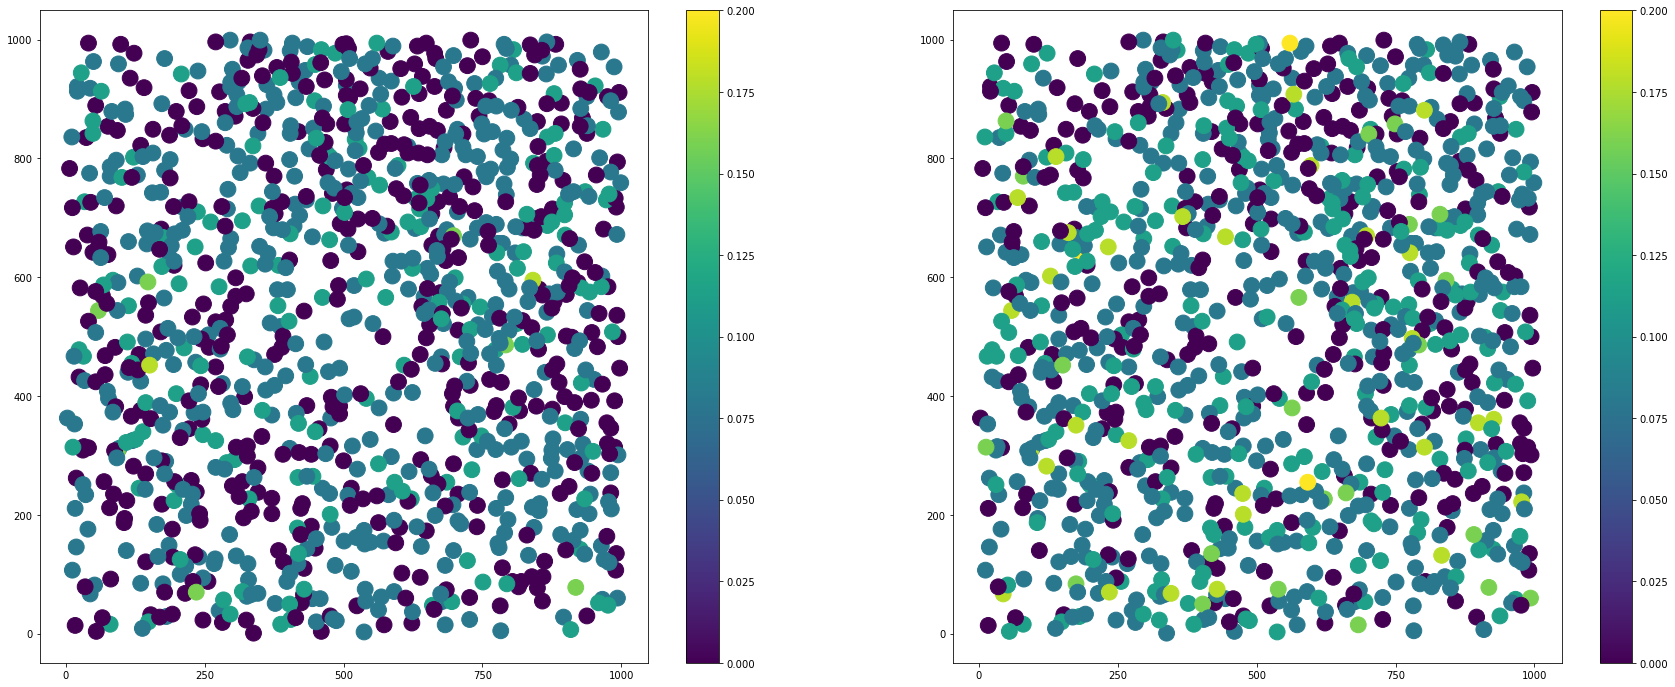

In [9]:
# check distances again and match new pairs after deletion of elements, and plot a map of distances

# post-extra calibration
d_shortest_final = []
idxs = []
for idx_t, transf_pair in enumerate(zip(transf_x_final_px,transf_y_final_px)):
    d_short = np.inf
    idx_short = 0
    for idx_s, scan_pair in enumerate(zip(scan_x_px,scan_y_px)):
        d = distance(transf_pair, scan_pair)
        if d < d_short:
            d_short = d
            idx_short = idx_s
    idxs.append([idx_t, idx_short])
    d_shortest_final.append(d_short)

idxs = np.array(idxs)
d_shortest_final = np.array(d_shortest_final)

fig1, axs = plt.subplots(1, 2, figsize=(30,12))
scatplot = axs[0].scatter(scan_x_px, scan_y_px, s=1000, c=d_shortest_final*pxs, cmap='viridis', marker='.', vmax=0.2)
cb = fig1.colorbar(scatplot, ax=axs[0])
print(np.mean(d_shortest_final))

# pre-extra calibration
d_shortest = []
idxs = []
for idx_t, transf_pair in enumerate(zip(transf_x_px,transf_y_px)):
    d_short = np.inf
    idx_short = 0
    for idx_s, scan_pair in enumerate(zip(scan_x_px,scan_y_px)):
        d = distance(transf_pair, scan_pair)
        if d < d_short:
            d_short = d
            idx_short = idx_s
    idxs.append([idx_t, idx_short])
    d_shortest.append(d_short)

idxs = np.array(idxs)
d_shortest = np.array(d_shortest)

scatplot = axs[1].scatter(scan_x_px, scan_y_px, s=1000, c=d_shortest*pxs, cmap='viridis', marker='.', vmax=0.2)
cb = fig1.colorbar(scatplot, ax=axs[1])
print(np.mean(d_shortest))

matplotlib.rcParams.update({'font.size': 40})

save = False
if save:
    savepath = 'example_data'
    plt.savefig(os.path.join(savepath, 'transf_allbeads_offset.tif'))

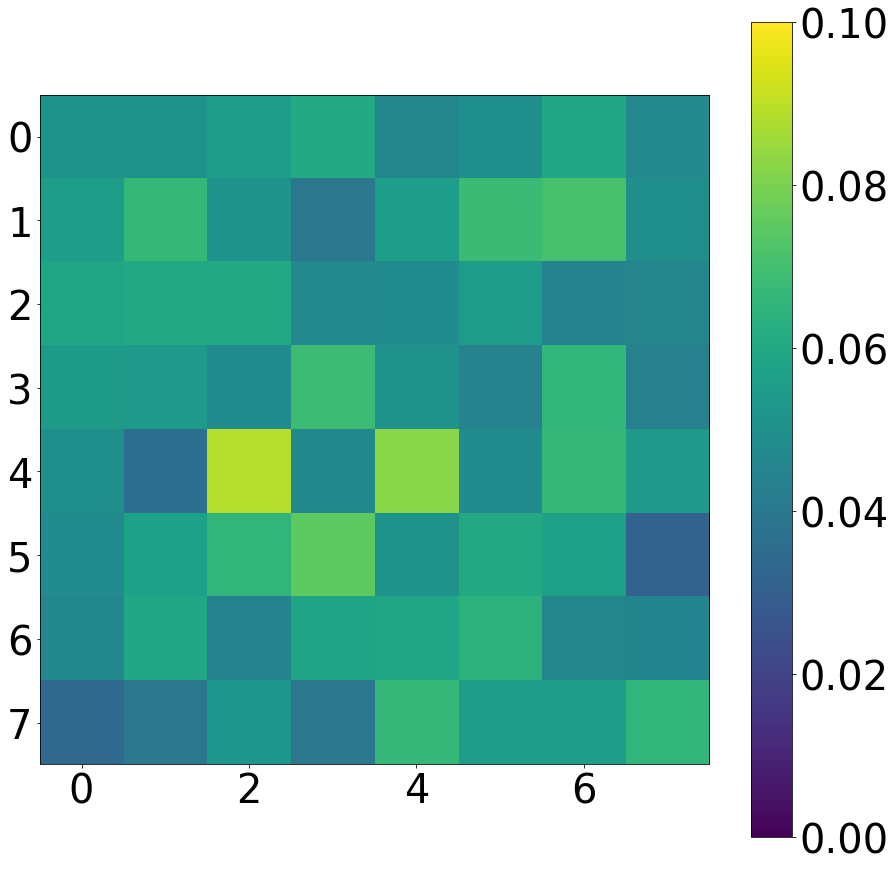

In [10]:
f_scale = 120
distimg = np.zeros([int(imsize/pxs/f_scale),int(imsize/pxs/f_scale)])

count = 0
idxs = []
transf_points = np.vstack([transf_x_final_px, transf_y_final_px]).T
for x in range(int(imsize/pxs/f_scale)):
    x_lim = [x*f_scale, x*f_scale + f_scale]
    for y in range(int(imsize/pxs/f_scale)):
        y_lim = [y*f_scale, y*f_scale + f_scale]
        d_avg = []
        for idx, transf_pair in enumerate(zip(transf_x_final_px, transf_y_final_px, d_shortest_final)):
            if transf_pair[0] > x_lim[0] and transf_pair[0] < x_lim[1] and transf_pair[1] > y_lim[0] and transf_pair[1] < y_lim[1]:
                count += 1
                idxs.append(idx)
                d_avg.append(transf_pair[2])
        distimg[x,y] = np.mean(d_avg)*pxs
plt.figure(figsize=(15,15))
distplot = plt.imshow(distimg, vmin=0, vmax=0.1)
plt.colorbar(distplot)

#savepath = 'E:\\Dokument\\Dropbox (Personlig)\\KTH\\PhD\\EventTriggeredSTED\\Figures\\Figure2'
#tifffile.imsave(os.path.join(savepath, 'transformation_map.tif'), distimg)

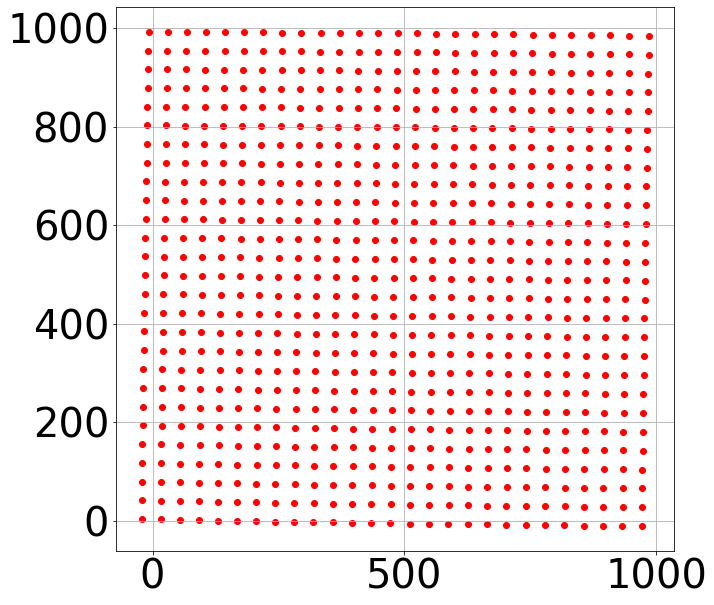

In [11]:
# plot transformed "grid lines" made up of transformed points
xx = np.arange(0,800,30)
yy = np.arange(0,800,30)
plt.figure(figsize=(10,10))
for x in xx:
    for y in yy:
        point = (x, y)
        transf_point = poly_thirdorder_transform(transform_coeffs, point)
        plt.scatter(transf_point[0]/pxs+500,transf_point[1]/pxs+500,facecolor='red')
plt.grid()